<a target="_blank" href="https://colab.research.google.com/github/juanhuguetgarcia/intro_to_llms/blob/main/intro_to_llms/2_langgraph_our_calculator_agent.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# 🧑‍🏫 Tutorial: Building Your First AI Agent with LangGraph, LangChain & Pydantic

Here’s a step-by-step interactive guide to understand how to build our first AI agent using:

* 🧠 LangChain for agent logic
* 🔁 LangGraph for orchestration
* 📦 Pydantic for clean state structure
* 🧮 Calculator tool for real functionality

In this notebook, we’re going to build a simple AI agent that can answer math questions like:

“What is 24 * 3?”

We’ll do it step by step. Here’s what we’re going to do:

## 🧱 Step 1: Define What Our Agent Needs to Know (the “state”)

We’ll create a little box of information (called state) where we put:
* the question we ask (input)
* the answer the agent gives us (output)

To keep things clean and organized, we’ll use a little helper called Pydantic.
Think of it like a smart checklist that makes sure our box always has the right items.

## 🔢 Step 2: Create a Typed Calculator Tool Using @tool

Instead of passing in a string like "24 * 3" and parsing it with eval, we’re going to build a real Python function that accepts two numbers and returns the result.

LangChain allows us to turn any function into an AI tool using a special decorator called @tool.

## 🤖 Step 3: Build the Agent

We’ll connect the tool to an AI model using LangChain. The AI will be smart enough to:
* read the question,
* choose the calculator if needed,
* return the answer.

This is the brain of our agent.

## 🔄 Step 4: Create a Graph (Flow)

We’ll then tell LangGraph:
	•	where to start,
	•	what steps to follow,
	•	and where to end.

This is like drawing a simple flowchart:
→ Get the question → Use the agent → Return the answer

## ▶️ Step 5: Run It!

Finally, we’ll give it a question like "What is 12 * 6?", and watch the agent respond with the right answer.

# Install required packages

Packages required: langgraph, langchain_openai and langchain_core

In [1]:
# Install LangGraph and langchain packages
%pip install --quiet -U langgraph langchain_openai langchain_core python-dotenv pydantic


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Set Open AI Key

Set the api key in the .env variable

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
import os
print(os.environ.get("OPENAI_API_KEY")[:10] + "...")

sk-proj-Gx...


### 🧱 Step 1: Define What Our Agent Needs to Know (the “state”)
We’ll create a little box of information (called state) where we put:

* the question we ask (input_msg)

* the answer the agent gives us (output_msg)

To keep things clean and organized, we’ll use a little helper called Pydantic. Think of it like a smart checklist that makes sure our box always has the right items.

🧠 Why Pydantic?
* Provides type safety and autocomplete in editors
* Ensures clean, validated state
* Avoids messy dicts and typos
* **LangGraph supports it natively for StateGraph**

In [4]:
from pydantic import BaseModel
from typing import Union

class AgentState(BaseModel):
    input: str
    output: str = ""  # this will be updated after tool execution

We can check that pydantic is giving us a nice representation...

In [5]:
print(AgentState(**{"input": "ping", "output": "pong"}).model_dump_json(indent=2))

{
  "input": "ping",
  "output": "pong"
}


### 🔢 Step 2: Create a Typed Calculator Tool Using @tool

Instead of passing in a string like "24 * 3" and parsing it with eval, we’re going to build a real Python function that accepts two numbers and returns the result.

LangChain allows us to turn any function into an AI tool using a special decorator called @tool

🧠 Why Use @tool?

Using @tool is:
* 🔐 Safe — no risky parsing or code execution like eval
* 🧼 Clean — LangChain will automatically read:
- the function name (calculate)
- the parameter names and types (a: int, b: int)
- the docstring to describe the tool
- 🤖 Agent-friendly — the agent will now know exactly how to use this tool: “If I get a question like ‘What is 5 plus 7?’, I can call calculate(a=5, b=7).”

In [6]:
from langchain.tools import tool
@tool
def calculate(a: int, b: int) -> str:
    """Adds two integers a and b."""
    return str(a + b)

We can see how it actually it adds a pydantic model with the metadata...

In [7]:
type(calculate.args_schema)

pydantic._internal._model_construction.ModelMetaclass

In [8]:
calculate.args_schema.model_json_schema()

{'description': 'Adds two integers a and b.',
 'properties': {'a': {'title': 'A', 'type': 'integer'},
  'b': {'title': 'B', 'type': 'integer'}},
 'required': ['a', 'b'],
 'title': 'calculate',
 'type': 'object'}

In [9]:
calculate.args

{'a': {'title': 'A', 'type': 'integer'},
 'b': {'title': 'B', 'type': 'integer'}}

### 🤖 Step 3: Build the Agent

Now that we have a proper tool defined, let’s create the agent that knows how to use it.

🧠 What’s Going On Here?

Initialize_agent sets up a reasoning agent that knows how to:

* Interpret your question
* Decide whether a tool is needed
* Call that tool with the right parameters
* Return the final answer
* `AgentType.STRUCTURED_CHAT_ZERO_SHOT_REACT_DESCRIPTION` is perfect for functions with multiple inputs:
    * It uses tool descriptions and the prompt itself to choose actions
    * No need to hard-code logic

In [10]:
from langchain.agents import initialize_agent, AgentType
from langchain_openai.chat_models import ChatOpenAI

# Create the LLM (you can replace with any compatible model)
llm = ChatOpenAI(temperature=0)

# Initialize the agent with our tool
agent_executor = initialize_agent(
    tools=[calculate],
    llm=llm,
    agent=AgentType.STRUCTURED_CHAT_ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True
)

/var/folders/pw/62h861vd4_d7w_csm70krjy80000gn/T/ipykernel_48864/1515712932.py:8: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. For details, refer to the `LangGraph documentation <https://langchain-ai.github.io/langgraph/>`_ as well as guides for `Migrating from AgentExecutor <https://python.langchain.com/docs/how_to/migrate_agent/>`_ and LangGraph's `Pre-built ReAct agent <https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/>`_.
  agent_executor = initialize_agent(


In [11]:
agent_executor.invoke("how much is two + four")



> Entering new AgentExecutor chain...
Thought: I can use the calculate tool to add two integers together.
Action:
```
{
  "action": "calculate",
  "action_input": {"a": 2, "b": 4}
}
```
Observation: 6
Thought:I have calculated that two plus four equals six.
Action:
```
{
  "action": "Final Answer",
  "action_input": "The sum of two plus four is six."
}
```

> Finished chain.


{'input': 'how much is two + four',
 'output': 'The sum of two plus four is six.'}

### 🧠 Step 5: Create a Node That Runs the Agent

In LangGraph, we wrap each step in a function that takes the current state, does something, and returns the updated state.

💡 Reminder: What’s “State”?

Think of AgentState as a box that carries:
* input: what the user asked
* output: what the agent answered

Each LangGraph node receives the box, modifies it, and passes it on.

In [12]:
## we have defined the AgentState above

# Node that runs the agent
def run_agent(state: AgentState) -> AgentState:
    result = agent_executor.run(state.input)
    return AgentState(input=state.input, output=result)

## Create the Graph

Create a node that calls LLM

As there are no other nodes, we will connect the START and the END to this node and compile.

## Understanding LangGraph Components

🧠 Why Use a Graph Here?

LangGraph lets us define structured flows:

* In this example, it’s a single-node graph
* Later, we can add conditional branches, tools, memory, retries, etc.
* It also gives us visualization and execution tracing for free


In [13]:
from langgraph.graph import StateGraph, END

graph = StateGraph(AgentState)

# Add our only node: the agent itself
graph.add_node("agent", run_agent)

# Define the flow: start at the agent, then end
graph.set_entry_point("agent")
graph.add_edge("agent", END)

# Compile it
app = graph.compile()

## Visualize the graph

Visualize the graph using display() method

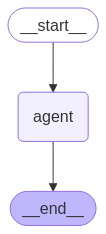

In [14]:
# Visualize your graph
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

# Test

Test the graph using app.invoke() method.


In [15]:
app.invoke({"input": "What is 13 plus 29?"})

/var/folders/pw/62h861vd4_d7w_csm70krjy80000gn/T/ipykernel_48864/607997069.py:5: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = agent_executor.run(state.input)




> Entering new AgentExecutor chain...
Thought: I can use the calculate tool to find the sum of 13 and 29.
Action:
```
{
  "action": "calculate",
  "action_input": {"a": 13, "b": 29}
}
```
Observation: 42
Thought:I can provide the final answer to the user's question about the sum of 13 and 29.
Action:
```
{
  "action": "Final Answer",
  "action_input": "The sum of 13 and 29 is 42."
}
```

> Finished chain.


{'input': 'What is 13 plus 29?', 'output': 'The sum of 13 and 29 is 42.'}

## ✅ Recap

You just built a real AI agent that can:
* Understand natural language
* Choose a Python tool to use
* Return accurate results

You used:
* Pydantic to structure state
* LangChain to build the agent
* LangGraph to control the flow

## Bonus

Let’s add a second tool and introduce branching logic in the graph so your students can learn how LangGraph routes input based on content.

## 🎯 Goal

* Add a second tool: get_time() → returns the current time.
* Add a classifier node that decides:
    * If the question is about math → use the calculator agent
    * If the question is about time → use the time tool

Use add_conditional_edges to route input based on type

In [16]:
from langchain.tools import tool
from datetime import datetime

@tool
def get_time() -> str:
    """Returns the current time."""
    return datetime.now().strftime("%H:%M:%S")

## 🧠 2. Update Agent Tool List

Update the agent with both tools (note: only calculate needs structured input):

In [17]:
agent_executor = initialize_agent(
    tools=[calculate, get_time],
    llm=llm,
    agent=AgentType.STRUCTURED_CHAT_ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True
)

## 🧠 3. Define a Classifier Node

This node routes inputs to the correct node:

In [56]:
class AgentStateBranch(BaseModel):
    input: str
    output: str = ""
    branch: Literal["math","time"] = "math"

In [58]:
from typing import Literal

def classify_question(state: AgentStateBranch) -> AgentStateBranch:
    text = state.input.lower()
    if "time" in text:
        branch = "time"
    else:
        branch = "math"
    return AgentState(
      input=state.input,
      output=state.output,
      branch=branch
    )

### ⚙️ 4. Define a Time Tool Node

We wrap the get_time() tool into a node:

In [59]:
def run_time_tool(state: AgentStateBranch) -> AgentStateBranch:
    result = get_time.invoke({})
    return AgentState(input=state.input, output=result)

### Rebuild the graph

In [60]:
from langgraph.graph import StateGraph, START, END

# Build the LangGraph with Branching
graph = StateGraph(AgentStateBranch)

# Nodes
graph.add_node("classify", classify_question)
graph.add_node("math_agent", run_agent)
graph.add_node("time_tool", run_time_tool)

# Flow
graph.add_edge(START, "classify")  # ✅ Kick off at START
graph.add_conditional_edges("classify", lambda s: s.branch, {
    "math": "math_agent",
    "time": "time_tool"
})

graph.add_edge("math_agent", END)
graph.add_edge("time_tool", END)

# Compile
app = graph.compile()

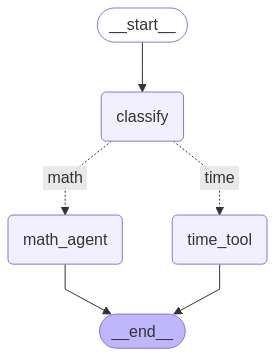

In [61]:
# Visualize your graph
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [62]:
print(app.invoke({"input": "What is 6 + 9?"}))



> Entering new AgentExecutor chain...
Thought: I can use the calculate tool to find the sum of 6 and 9.
Action:
```
{
  "action": "calculate",
  "action_input": {"a": 6, "b": 9}
}
```
Observation: 15
Thought:I have calculated that 6 + 9 equals 15.

> Finished chain.
{'input': 'What is 6 + 9?', 'output': 'I have calculated that 6 + 9 equals 15.'}


In [63]:
print(app.invoke({"input": "What time is it ?"}))



> Entering new AgentExecutor chain...
Thought: I can use the "get_time" tool to find out the current time.
Action:
```
{
  "action": "get_time",
  "action_input": {}
}
```
Observation: 16:20:01
Thought:I have just checked the current time. It is 16:20:01.
Thought: I should provide this time to the user.
Action:
```
{
  "action": "Final Answer",
  "action_input": "The current time is 16:20:01."
}
```

> Finished chain.
{'input': 'What time is it ?', 'output': 'The current time is 16:20:01.'}
